___

# SOLVING TITANIC CHALLENGE WITH KNN
___
## Competition Description
The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.
One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.
In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

___
## Imports section

In [24]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (15,5)

import seaborn as sns

from sklearn.cross_validation import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, classification_report

from matplotlib.colors import ListedColormap

___
## Data Exploring

### Read dataset and show head

In [25]:
train_dataset = pd.read_csv('titanic_train.csv')
train_dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Data Info

#### heatmap on missing data

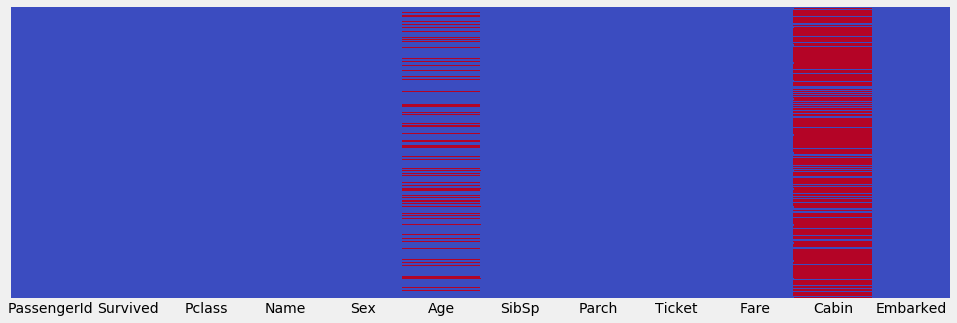

In [26]:
sns.heatmap(train_dataset.isnull(), yticklabels=False, cbar=False, cmap='coolwarm')

#### suvivors vs features

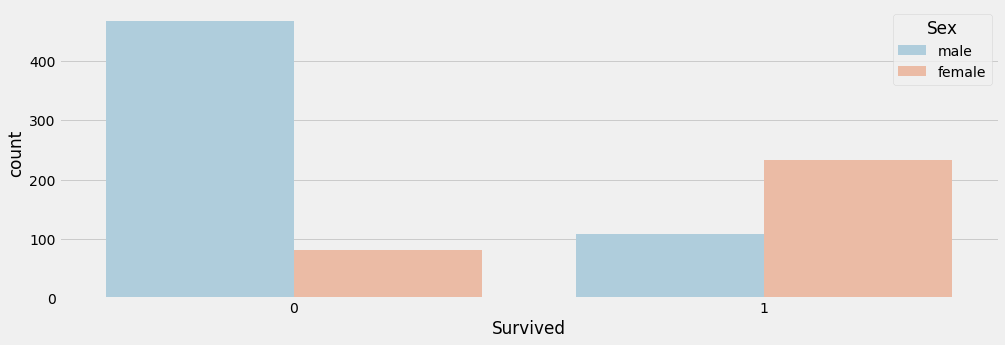

In [27]:
sns.countplot(x='Survived', data=train_dataset, hue='Sex', palette= 'RdBu_r')    

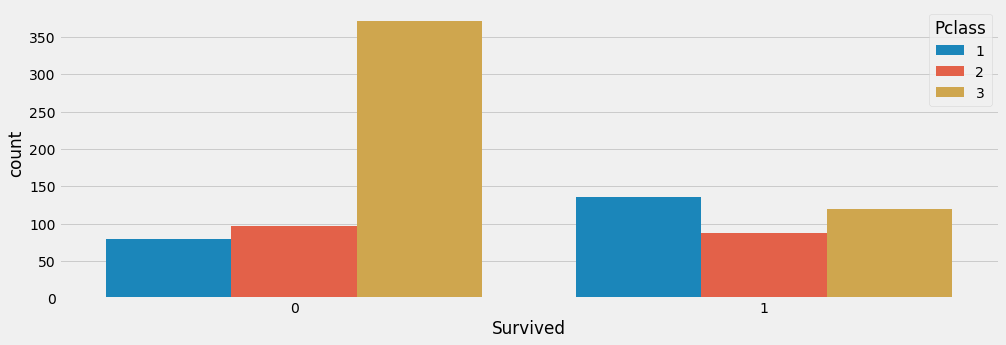

In [28]:
sns.countplot(x='Survived', data=train_dataset, hue='Pclass' )    

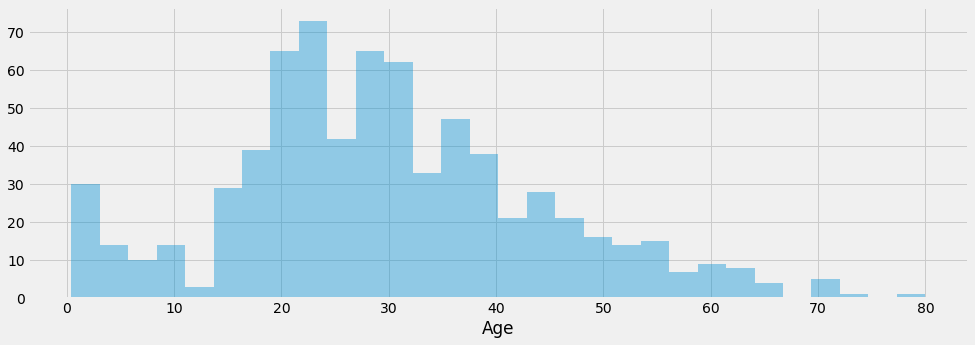

In [29]:
sns.distplot(train_dataset['Age'].dropna(), kde=False, bins=30)

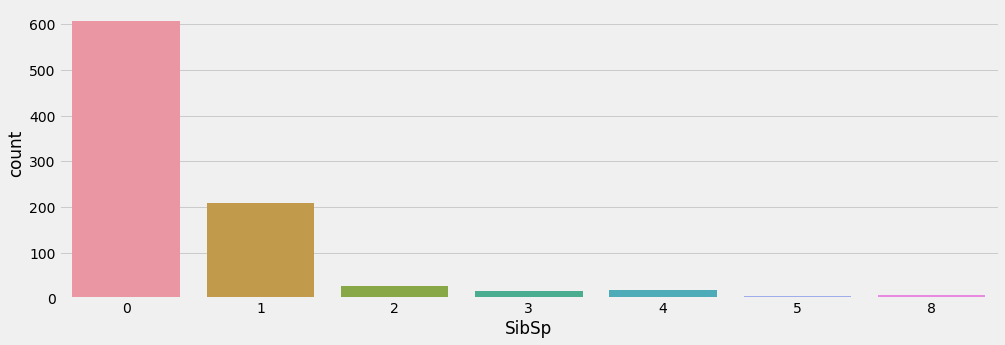

In [30]:
sns.countplot(x='SibSp', data= train_dataset)

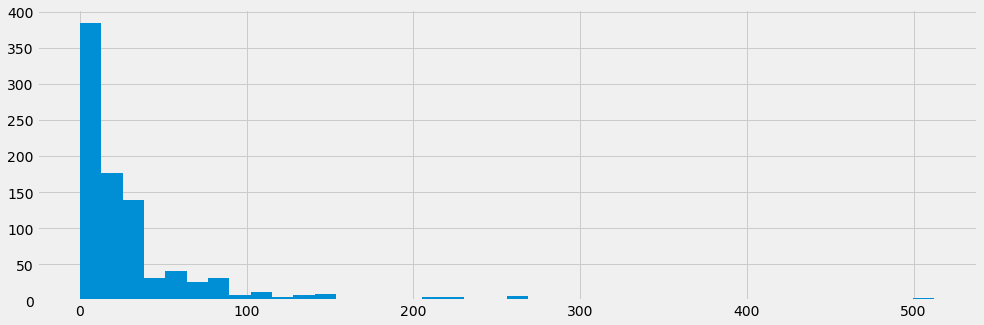

In [31]:
train_dataset['Fare'].hist(bins=40)

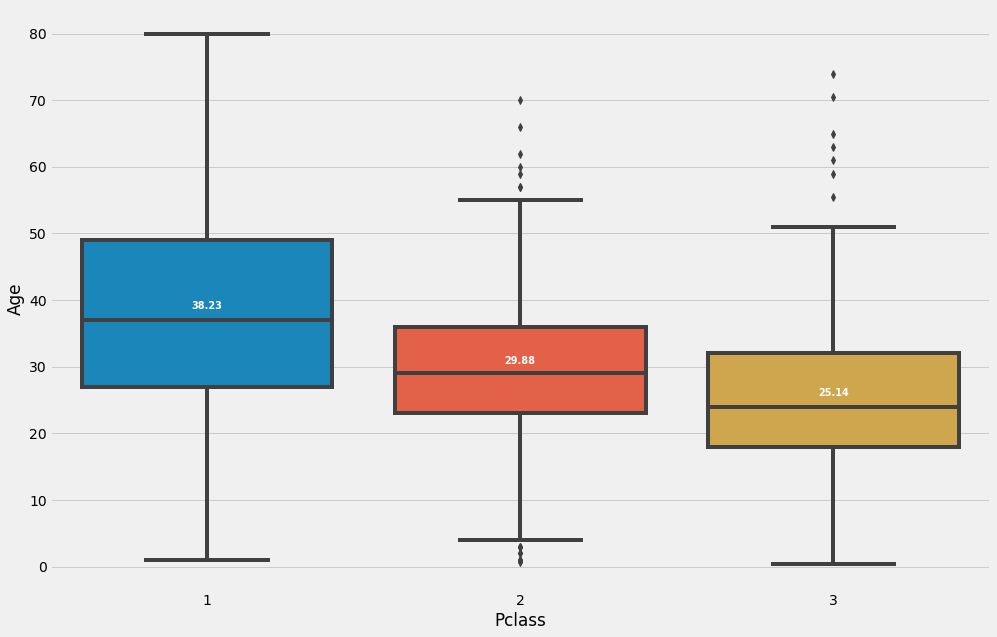

In [32]:
plt.figure(figsize=(15,10))
means = train_dataset.groupby(['Pclass'])['Age'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
ax = sns.boxplot(x='Pclass', y='Age', data=train_dataset )
pos = range(len(means))
for tick,label in zip(pos, ax.get_xticklabels()):
    ax.text(pos[tick], means[tick] + 0.5, mean_labels[tick], 
            horizontalalignment='center', size='x-small', color='w', weight='semibold')

___
## Data Processing

### Dealing with Missing Data

In [33]:
def impute_age(cols):
    means = train_dataset.groupby(['Pclass'])['Age'].mean().values
    age = cols[0]
    pclass = cols[1]
    if (pd.isnull(age)):
        return means[int(pclass)-1]
    return age

In [34]:
train_dataset['Age'] = train_dataset[['Age','Pclass']].apply(impute_age, axis=1)

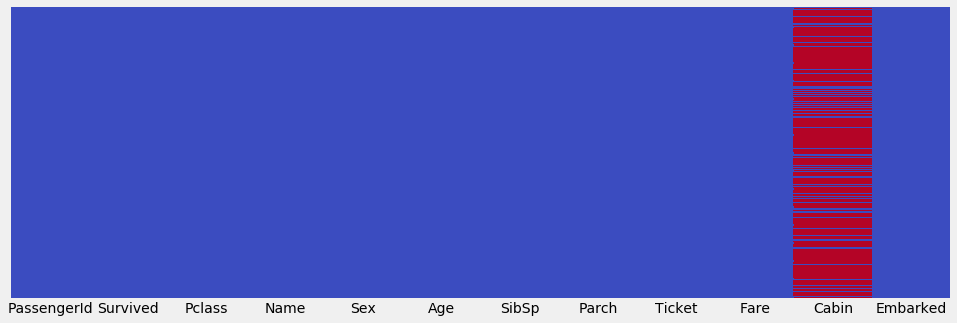

In [35]:
sns.heatmap(train_dataset.isnull(), yticklabels=False, cbar=False, cmap='coolwarm')

### Encoding Categorical Data

In [36]:
sex_dummies = pd.get_dummies(train_dataset['Sex'], drop_first=True)
embarked_dummies = pd.get_dummies(train_dataset['Embarked'], drop_first=True)
pclass_dumies = pd.get_dummies(train_dataset['Pclass'], drop_first=True)
train_dataset = pd.concat([train_dataset,sex_dummies,embarked_dummies, pclass_dumies], axis=1)
train_dataset.drop(['Sex','Name','Ticket','PassengerId','Pclass', 'Embarked','Cabin','Fare'], axis=1, inplace=True)
train_dataset.dropna(inplace=True, axis=1)
train_dataset.head()

,Survived,Age,SibSp,Parch,male,Q,S,2,3
0,0,22.0,1,0,1,0,1,0,1
1,1,38.0,1,0,0,0,0,0,0
2,1,26.0,0,0,0,0,1,0,1
3,1,35.0,1,0,0,0,1,0,0
4,0,35.0,0,0,1,0,1,0,1


### Spliting the Data

In [37]:
X = train_dataset.drop('Survived', axis=1)
scaler = StandardScaler()
scaler =scaler.fit(X)
X = scaler.transform(X)
y = train_dataset['Survived']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.30, random_state=101)

___
## Model Desing

### Selecting the Best K

In [38]:
error_rate = []

for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0,0.5,'Error Rate')

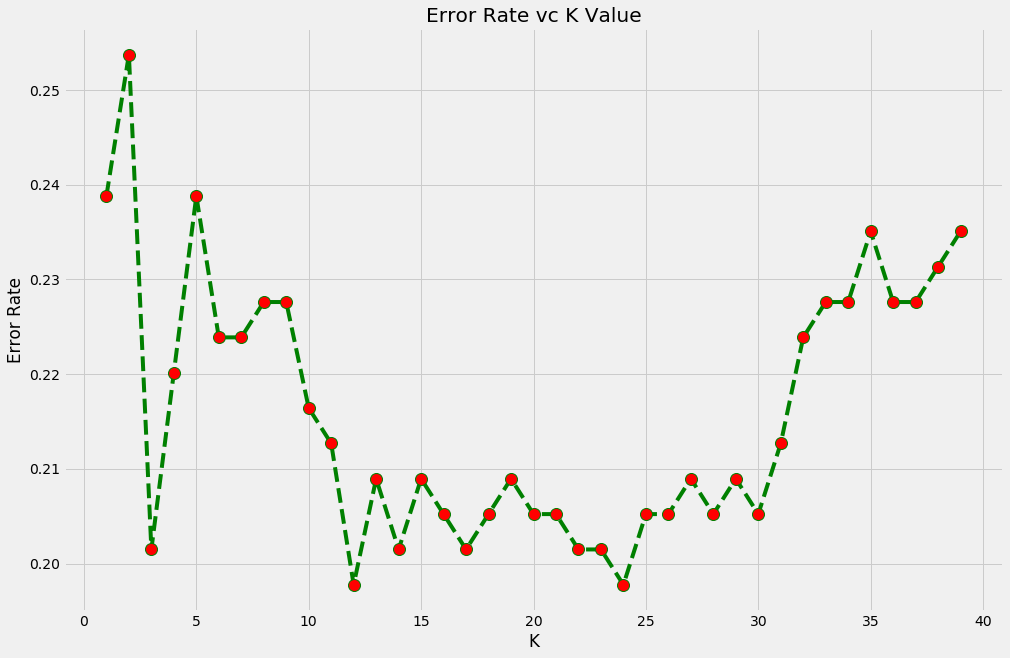

In [39]:
plt.figure(figsize=(15,10))
plt.plot(range(1,40), error_rate, color='green', linestyle='--', marker='o', markerfacecolor='red',
        markersize=12)
plt.title('Error Rate vc K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [40]:
min_error = min(error_rate)
k = error_rate.index(min_error) + 1
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)
preds = knn.predict(X_test)

In [41]:
print(classification_report(y_test, preds))
cm = confusion_matrix(y_true=y_test, y_pred= preds)
df_cm =pd.DataFrame(data=cm,index=['Real False', 'Real True'], columns=['Pred False', 'Pred True'])
df_cm

             precision    recall  f1-score   support

          0       0.76      0.95      0.85       154
          1       0.91      0.60      0.72       114

avg / total       0.82      0.80      0.79       268



,Pred False,Pred True
Real False,147,7
Real True,46,68


## Creating and training models

In [42]:
train_classifier = KNeighborsClassifier(n_neighbors=k)
train_classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=12, p=2,
           weights='uniform')

In [43]:
classifier = KNeighborsClassifier(n_neighbors=k)
classifier.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=12, p=2,
           weights='uniform')

### Predictions

In [44]:
train_predictions = train_classifier.predict(X_test)
test_dataset = pd.read_csv('processed_test_dataset.csv')
predictions = classifier.predict(test_dataset)

### Model Performace Analysis

In [45]:
print("********* On Train Dataset *********")
print(classification_report(y_test, train_predictions))
cm = confusion_matrix(y_true=y_test, y_pred= train_predictions)
df_cm =pd.DataFrame(data=cm,index=['Real False', 'Real True'], columns=['Pred False', 'Pred True'])
df_cm

********* On Train Dataset *********
             precision    recall  f1-score   support

          0       0.76      0.95      0.85       154
          1       0.91      0.60      0.72       114

avg / total       0.82      0.80      0.79       268



,Pred False,Pred True
Real False,147,7
Real True,46,68


### Submission

In [46]:
submission = pd.DataFrame()
submission['PassengerId'] = pd.read_csv('titanic_test.csv')['PassengerId']
submission['Survived'] = predictions

In [47]:
submission.to_csv('submission.csv', index=False)